# Methodology

 Here we want to extend the insights that Zeek and RITA are giving us about the probable sketchiness of particular connections. 
 
 While we're narrowing down things like beaconish traffic using statistical connection analysis, we can bring some local knowledge to add dimension. 
 
- Combine Beacons and Conns files to identify unique talkers
- retrieve BGP Autonomous Systems info to identify originators (or listeners) in Wild West zones
- Identify traffic from Insecure Countries

also - are we getting connections from nets that practice good hygiene? 
- is there a DNS entry?
- is there a PTR record

What local tools can add dimension?
- was the sender identified as malicious by fail2ban actions? (ICMP type 3 returns)

Open Blacklist entries:
- https://github.com/StevenBlack/hosts

In Addition - you may want to analyze office or home net traffic and find out chatty corporate tools. You can add your own, but this will add a score to tag "friendly surveillance" from Apple, Google, et al. My lists are US-Centric - tailor to your locale

This has some other helper tools, also. For example if you're publishing you may not desire to show off internal network specifics when publishing, so obscureIPs.py will reIP your local net/hosts to a range you specify (default 192.168.1.1).



In [1]:
# imports
import pandas as pd
import numpy as np

# Viz imports
import matplotlib.pyplot as plt
import seaborn as sns

# Config matplotlib
%matplotlib inline
plt.rcParams["patch.force_edgecolor"] = True # in matplotlib, edge borders are turned off by default.
sns.set_style("darkgrid") # set a grey grid as a background

# turn off warnings
import warnings
warnings.filterwarnings('ignore')

import csv
import json
import datetime as datetime
import time

# ip/AS lookup tools
import socket
from ipwhois import IPWhois
from ipwhois.net import Net
from ipwhois.asn import IPASN

In [2]:
# define corporate target AS Descriptors
invasive_corps = ['AMAZON','APPLE','GOOGLE','MICROSOFT','CLOUDFLARENET','SALESFORCE','AKAMAI','OPENDNS']
sketchy_countries = ['CN','RU','VN','HK','TW','IN','BR','RO','HU','KR','IT','UG','TR','MY','BO','CO']


In [3]:
sketchy_providers = []
providers = open('beaconish_asns','r').readlines()
for p in providers:
    sketchy_providers.append(p.split()[0])

In [4]:
sketchy_providers[:5]

['AS-SONICTELECOM,', 'ASIANET', 'ASN-SPIN,', 'ASN-WINDTRE', 'BAIDU']

### load data

this takes the output of rita show-long-connections (dfconns) and rita show-beacons (dfbeacons).

The obscured IPs must be the same for each file - we merge the two on a matched ipsrc->ipdst key. The df will fail to create if there is nothing to merge on.

In [5]:
dfbeacons = pd.read_csv('ext_20210315062437_beacons.csv')
dfconns = pd.read_csv('ext_20210315062437_longconns.csv')
#dfdns = pd.read_csv('dns.csv')

In [6]:
dfbeacons.head(1)

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,Top Size Count,Intvl Skew,Size Skew,Intvl Dispersion,Size Dispersion
0,0.874,122.194.229.37,192.168.23.89,43244,60,308072,2583,11,60,7773,43188,0.0,0.0,1,0


In [7]:
dfconns.head(1)

,Source IP,Destination IP,Port:Protocol:Service,Duration
0,97.113.95.12,192.168.23.89,53718:tcp:- 53716:tcp:- 44496:tcp:- 44494:tcp:...,367302.0


### merge 

In [8]:
dfconns['ConnString'] = dfconns['Source IP'] + '->' + dfconns['Destination IP']

In [9]:
dfbeacons['ConnString'] = dfbeacons['Source IP'] + '->'+ dfbeacons['Destination IP']

In [10]:
df = pd.merge(dfbeacons, dfconns, on=['ConnString'], how='inner')

In [11]:
df.head(5)

,Score,Source IP_x,Destination IP_x,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,Top Size Count,Intvl Skew,Size Skew,Intvl Dispersion,Size Dispersion,ConnString,Source IP_y,Destination IP_y,Port:Protocol:Service,Duration
0,0.835,65.254.18.118,192.168.23.89,1224,88,101090,7306,600,60,1052,1201,0.0,0.0,0,0,65.254.18.118->192.168.23.89,65.254.18.118,192.168.23.89,25:tcp:- 25:tcp:smtp,596.079
1,0.834,104.153.105.82,192.168.23.89,272,1762,356385,147842,1,0,81,189,0.0,0.0,0,0,104.153.105.82->192.168.23.89,104.153.105.82,192.168.23.89,80:tcp:- 443:tcp:- 53:udp:dns,149.911
2,0.832,192.168.23.89,212.70.149.71,3005,104,7209,45408,110,88,930,2965,0.0,0.0,1,0,192.168.23.89->212.70.149.71,192.168.23.89,212.70.149.71,3:icmp:-,7123.610
3,0.828,49.235.37.144,192.168.23.89,112,126,179,1853,44,60,26,95,0.0,0.0,1,0,49.235.37.144->192.168.23.89,49.235.37.144,192.168.23.89,22:tcp:- 22:tcp:ssh,103.858
4,0.828,192.168.23.89,119.28.83.164,38,159,241,2192,62,88,9,34,0.0,0.0,1,0,192.168.23.89->119.28.83.164,192.168.23.89,119.28.83.164,3:icmp:-,237.145


### clean up merge data

since the merge key is an amagalm of connection to connection strings, the Source IP and Destination IP collision columns _x and _y should be erroneous.

**delete _ys and rename _x**

In [12]:
del df['Source IP_y']

In [13]:
del df['Destination IP_y']

In [14]:
df.rename(columns={"Destination IP_x": "Destination IP",'Source IP_x':'Source IP'}, inplace=True)

In [15]:
df.columns

Index(['Score', 'Source IP', 'Destination IP', 'Connections', 'Avg Bytes',
       'Intvl Range', 'Size Range', 'Top Intvl', 'Top Size', 'Top Intvl Count',
       'Top Size Count', 'Intvl Skew', 'Size Skew', 'Intvl Dispersion',
       'Size Dispersion', 'ConnString', 'Port:Protocol:Service', 'Duration'],
      dtype='object')

### adding hostname lookups

In [16]:
def iplookup(ipaddress):
    #print(ipaddress)
    try: 
        fullhostname = socket.gethostbyaddr(ipaddress)
        hostname = fullhostname[0]
    except Exception as e:
        hostname = ipaddress
    return hostname

In [17]:
df['Source Name'] = df['Source IP'].apply(iplookup)

In [18]:
# this takes awhile thanks to DNS timeouts
df['Destination Name'] = df['Destination IP'].apply(iplookup)

In [19]:
df.head()

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,Top Size Count,Intvl Skew,Size Skew,Intvl Dispersion,Size Dispersion,ConnString,Port:Protocol:Service,Duration,Source Name,Destination Name
0,0.835,65.254.18.118,192.168.23.89,1224,88,101090,7306,600,60,1052,1201,0.0,0.0,0,0,65.254.18.118->192.168.23.89,25:tcp:- 25:tcp:smtp,596.079,smtp.jobdivabk.com,192.168.23.89
1,0.834,104.153.105.82,192.168.23.89,272,1762,356385,147842,1,0,81,189,0.0,0.0,0,0,104.153.105.82->192.168.23.89,80:tcp:- 443:tcp:- 53:udp:dns,149.911,v-104-153-105-82.unman-vds.premium-chicago.nfo...,192.168.23.89
2,0.832,192.168.23.89,212.70.149.71,3005,104,7209,45408,110,88,930,2965,0.0,0.0,1,0,192.168.23.89->212.70.149.71,3:icmp:-,7123.610,192.168.23.89,212.70.149.71
3,0.828,49.235.37.144,192.168.23.89,112,126,179,1853,44,60,26,95,0.0,0.0,1,0,49.235.37.144->192.168.23.89,22:tcp:- 22:tcp:ssh,103.858,49.235.37.144,192.168.23.89
4,0.828,192.168.23.89,119.28.83.164,38,159,241,2192,62,88,9,34,0.0,0.0,1,0,192.168.23.89->119.28.83.164,3:icmp:-,237.145,192.168.23.89,119.28.83.164


### Describing the IP sets

In [20]:
# unique localhosts
len(df['Source IP'].unique())

116

In [21]:
df['Source IP'].unique()

array(['65.254.18.118', '104.153.105.82', '192.168.23.89',
       '49.235.37.144', '42.192.234.75', '45.119.126.59', '120.70.98.132',
       '61.221.64.5', '202.95.14.159', '190.210.182.179',
       '106.124.131.214', '157.131.240.195', '49.232.39.21',
       '211.219.18.186', '123.206.90.149', '190.85.94.106',
       '49.233.77.12', '114.219.157.97', '210.178.94.227',
       '118.212.146.30', '106.75.61.147', '129.211.119.202',
       '35.220.253.166', '119.45.177.219', '125.5.180.84',
       '134.175.111.215', '134.209.41.198', '189.110.163.26',
       '116.228.233.91', '190.171.133.10', '144.91.70.164',
       '101.89.213.84', '118.98.96.184', '64.64.227.224',
       '222.168.18.227', '103.10.87.54', '203.195.207.85',
       '121.4.111.232', '101.36.127.150', '2.196.193.181',
       '123.127.244.100', '121.241.244.92', '182.254.149.130',
       '81.68.243.13', '106.124.142.64', '1.220.185.149', '123.30.149.34',
       '103.55.62.78', '118.24.121.227', '120.92.166.166',
       '121.4

In [22]:
# unique targets
len(df['Destination IP'].unique())

640

In [23]:
# unique connections
len(df['ConnString'].unique())

754

### update AS info

feature engineering AS info

In [24]:
newcols = ['asn_registry', 'asn', 'asn_cidr', 'asn_country_code', 'asn_date', 'asn_description']

In [30]:
def getAsInfo(ipaddress, category='asn', **kwargs):
    """
    df['Destination IP'].apply(getAsInfoKwargs, category='asncidr',axis=1)
    """
    private = ['10.','172.','192.168.']
    if '192.168' in ipaddress:
        return 'rfc1918'
    net = Net(ipaddress)
    obj = IPASN(net)
    results = obj.lookup()
    if category is None:
        return "no category"
        #print(category)
    
    if category == 'reg':
        return results['asn_registry']
    elif category == 'asnnum':
        return results['asn']
    elif category == 'asncidr':
        return results['asn_cidr']
    elif category == 'asncc':
        return results['asn_country_code']
    elif category == 'asndate':
        return results['asn_date']
    elif category == 'asndesc':
        return results['asn_description']
    else:
        return False
    

#### add ASN columns

In [32]:
# add asncidr
df['asncidr'] = df['Destination IP'].apply(getAsInfo, category='asncidr',axis=1)

In [33]:
df['asn'] = df['Destination IP'].apply(getAsInfo, category='asnnum',axis=1)

In [34]:
df['asn_desc'] = df['Destination IP'].apply(getAsInfo, category='asndesc',axis=1)

In [35]:
df['asn_country'] = df['Destination IP'].apply(getAsInfo, category='asncc',axis=1)

In [36]:
df.head(3)

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,Size Dispersion,ConnString,Port:Protocol:Service,Duration,Source Name,Destination Name,asncidr,asn,asn_desc,asn_country
0,0.835,65.254.18.118,192.168.23.89,1224,88,101090,7306,600,60,1052,...,0,65.254.18.118->192.168.23.89,25:tcp:- 25:tcp:smtp,596.079,smtp.jobdivabk.com,192.168.23.89,rfc1918,rfc1918,rfc1918,rfc1918
1,0.834,104.153.105.82,192.168.23.89,272,1762,356385,147842,1,0,81,...,0,104.153.105.82->192.168.23.89,80:tcp:- 443:tcp:- 53:udp:dns,149.911,v-104-153-105-82.unman-vds.premium-chicago.nfo...,192.168.23.89,rfc1918,rfc1918,rfc1918,rfc1918
2,0.832,192.168.23.89,212.70.149.71,3005,104,7209,45408,110,88,930,...,0,192.168.23.89->212.70.149.71,3:icmp:-,7123.610,192.168.23.89,212.70.149.71,212.70.149.0/24,208410,"INTERNET-HOSTING, BG",BG


**how many are unique?**

In [37]:
len(df['asn'].unique())

197

In [38]:
df['asn'].unique()[:10]

array(['rfc1918', '208410', '132203', '14061', '45090', '4134', '28361',
       '64050', '9498', '55720'], dtype=object)

In [39]:
len(df['asn_country'].unique())

58

In [40]:
df['asn_country'].unique()

array(['rfc1918', 'BG', 'CN', 'US', 'BR', 'SG', 'IN', 'MY', 'HK', 'RU',
       'ES', 'CO', 'TH', 'AU', 'ID', 'FR', 'CA', 'GB', 'PA', 'VN', 'HR',
       'KR', 'BO', 'VE', 'PH', 'SC', 'IT', 'PE', 'AR', 'SV', 'TR', 'TW',
       'JP', 'PT', 'MX', 'ZA', 'NG', 'GT', 'TN', 'MN', 'DE', 'CL', 'BY',
       'IR', 'PS', 'SE', 'PK', 'NL', 'CH', 'LA', 'MM', 'PL', 'KE', 'BE',
       'EC', 'IS', 'GR', 'EG'], dtype=object)

In [41]:
countries = df['asn_country'].unique()

In [42]:
df[df['asn_desc']!= 'rfc1918'][:5]

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,Size Dispersion,ConnString,Port:Protocol:Service,Duration,Source Name,Destination Name,asncidr,asn,asn_desc,asn_country
2,0.832,192.168.23.89,212.70.149.71,3005,104,7209,45408,110,88,930,...,0,192.168.23.89->212.70.149.71,3:icmp:-,7123.610,192.168.23.89,212.70.149.71,212.70.149.0/24,208410,"INTERNET-HOSTING, BG",BG
4,0.828,192.168.23.89,119.28.83.164,38,159,241,2192,62,88,9,...,0,192.168.23.89->119.28.83.164,3:icmp:-,237.145,192.168.23.89,119.28.83.164,119.28.82.0/23,132203,"TENCENT-NET-AP-CN Tencent Building, Kejizhongy...",CN
5,0.823,192.168.23.89,157.230.210.84,42,226,220,1944,208,88,7,...,0,192.168.23.89->157.230.210.84,3:icmp:-,117.083,192.168.23.89,157.230.210.84,157.230.208.0/20,14061,"DIGITALOCEAN-ASN, US",US
6,0.823,192.168.23.89,49.233.77.12,102,162,268,2564,85,88,15,...,0,192.168.23.89->49.233.77.12,3:icmp:-,258.820,192.168.23.89,49.233.77.12,49.233.64.0/20,45090,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,CN
7,0.823,192.168.23.89,27.128.236.189,114,140,162,2036,80,88,19,...,0,192.168.23.89->27.128.236.189,3:icmp:-,156.136,192.168.23.89,27.128.236.189,27.128.0.0/15,4134,"CHINANET-BACKBONE No.31,Jin-rong Street, CN",CN


In [43]:
df[['asn','asn_desc','Source IP']].value_counts()

asn      asn_desc                                                                    Source IP    
45090    CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer Systems Company Limited, CN  192.168.23.89    173
14061    DIGITALOCEAN-ASN, US                                                        192.168.23.89     91
4134     CHINANET-BACKBONE No.31,Jin-rong Street, CN                                 192.168.23.89     31
16276    OVH, FR                                                                     192.168.23.89     26
56046    CMNET-JIANGSU-AP China Mobile communications corporation, CN                192.168.23.89     15
                                                                                                     ... 
38019    CMNET-V4TIANJIN-AS-AP tianjin Mobile Communication Company Limited, CN      192.168.23.89      1
38511    TACHYON-AS-ID PT Remala Abadi, ID                                           192.168.23.89      1
40021    CONTABO, US                                 

#### add AS Features

 Add booleans if the connection is either a known invasive tech company or in the sketchy country list.

In [44]:
def is_sketchy(asn):
    return True if asn in sketchy_countries else False 

In [45]:
def is_corp(asn):
    return True if asn in invasive_corps else False

In [46]:
def is_sketchy_provider(asn):
    
    return True if asn in sketchy_providers else False

In [47]:
len(df[df['asn_country'].apply(is_sketchy)])

383

In [48]:
df['sketchy'] = df['asn_country'].apply(is_sketchy)

In [49]:
df['iscorp'] = df['asn_desc'].apply(is_corp)

In [50]:
df['sketchy_provider'] = df['asn_desc'].apply(is_sketchy_provider)

In [51]:
df.head(3)

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,Duration,Source Name,Destination Name,asncidr,asn,asn_desc,asn_country,sketchy,iscorp,sketchy_provider
0,0.835,65.254.18.118,192.168.23.89,1224,88,101090,7306,600,60,1052,...,596.079,smtp.jobdivabk.com,192.168.23.89,rfc1918,rfc1918,rfc1918,rfc1918,False,False,False
1,0.834,104.153.105.82,192.168.23.89,272,1762,356385,147842,1,0,81,...,149.911,v-104-153-105-82.unman-vds.premium-chicago.nfo...,192.168.23.89,rfc1918,rfc1918,rfc1918,rfc1918,False,False,False
2,0.832,192.168.23.89,212.70.149.71,3005,104,7209,45408,110,88,930,...,7123.610,192.168.23.89,212.70.149.71,212.70.149.0/24,208410,"INTERNET-HOSTING, BG",BG,False,False,False


### Network sanity

**is there a ptr?**

In [52]:
df['Source Name'][0]

'smtp.jobdivabk.com'

In [53]:
def isip(id):
    """
    is the string an ipv4 address?
    """
    try: 
        socket.inet_aton(id)
        return True
    except:
        return False

In [54]:
def has_dns(id):
    """
    earlier we checked for a dns entry and return an IP if none is found.
    here we say "if that id is an IP then there was no DNS record"
    """
    try: 
        socket.inet_aton(id)
        return False
    except:
        return True

In [55]:
def has_ptr(id):
    """
    earlier we checked for a ptr and return an IP if none is found.
    here we say "if that id is an IP then there was no PTR record"
    """
    try: 
        socket.inet_aton(id)
        return False
    except:
        return True

In [56]:
df['Source Name'].apply(isip)

0      False
1      False
2       True
3       True
4       True
       ...  
749     True
750     True
751     True
752     True
753     True
Name: Source Name, Length: 754, dtype: bool

In [57]:
df['src_ptr'] = df['Source Name'].apply(has_ptr)
df['dst_ptr'] = df['Destination Name'].apply(has_ptr)
df['src_dns'] = df['Source Name'].apply(has_dns)
df['dst_dns'] = df['Destination Name'].apply(has_dns)


In [58]:
df.head(3)

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,asn,asn_desc,asn_country,sketchy,iscorp,sketchy_provider,src_ptr,dst_ptr,src_dns,dst_dns
0,0.835,65.254.18.118,192.168.23.89,1224,88,101090,7306,600,60,1052,...,rfc1918,rfc1918,rfc1918,False,False,False,True,False,True,False
1,0.834,104.153.105.82,192.168.23.89,272,1762,356385,147842,1,0,81,...,rfc1918,rfc1918,rfc1918,False,False,False,True,False,True,False
2,0.832,192.168.23.89,212.70.149.71,3005,104,7209,45408,110,88,930,...,208410,"INTERNET-HOSTING, BG",BG,False,False,False,False,False,False,False


**did we miss any?**

In [59]:
# weird entry - whois returns the AS info, but no description or prefix
# AS      | IP               | BGP Prefix          | CC | Registry | Allocated  | AS Name
# NA      | 69.195.171.128   | NA                  | US | arin     | 2017-09-18 | NA
# From Hurricane Electric - Twitter:
# AS13414 IRR Valid 69.195.171.0/24 Twitter Inc.
df[df['asn'] == 'NA']

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,asn,asn_desc,asn_country,sketchy,iscorp,sketchy_provider,src_ptr,dst_ptr,src_dns,dst_dns
485,0.76,192.168.23.89,103.89.176.74,55,221,210,2164,135,88,3,...,NA,NA,MM,False,False,False,False,False,False,False


#### ICMP 3 means that the host was caught by fail2ban

this adds suspicion to the connection



In [60]:
len(df['Port:Protocol:Service'].unique())

13

In [61]:
df['Port:Protocol:Service'].value_counts()

3:icmp:-                                                       637
22:tcp:- 22:tcp:ssh                                             85
22:tcp:ssh 22:tcp:-                                             20
22:tcp:-                                                         3
48984:tcp:- 47468:tcp:- 51152:tcp:- 49894:tcp:- 37530:tcp:-      1
22:tcp:- 53:udp:dns                                              1
80:tcp:- 443:tcp:- 53:udp:dns                                    1
53718:tcp:- 53716:tcp:- 44496:tcp:- 44494:tcp:- 44498:tcp:-      1
17266:tcp:- 18676:tcp:- 3:icmp:-                                 1
25:tcp:- 53:udp:dns 25:tcp:smtp                                  1
25:tcp:- 25:tcp:smtp                                             1
443:tcp:- 80:tcp:- 443:tcp:ssl 80:tcp:http                       1
80:tcp:- 53:udp:dns 80:tcp:http 443:tcp:ssl 443:tcp:-            1
Name: Port:Protocol:Service, dtype: int64

In [62]:
#services = {'icmp':3,'ssh':22,'smtp':25,'dns':53,'ssl':443,'http':80}
services = ['icmp','ssh','smtp','dns','ssl','http']

In [63]:
def f2b_marked(s):
    """
    fail2ban responds to connection overload by replying with ICMP type 3 "unreachable"
    if this exists in the connection, we'll presume that this host was flooding
    """
    if 'icmp' in s:
        return True
    return False

In [64]:
# multiple match list
# [s for s in my_list if any(xs in s for xs in matchers)] # greedy - returns too much
# {s for s in my_list for xs in matchers if xs in s}

In [65]:
# add fail2ban hit feature
df['fail2ban'] = df['Port:Protocol:Service'].apply(f2b_marked)

### some simple aggregated term analysis


In [66]:
# sketchy is false
df[~df['sketchy']][:3]

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,asn_desc,asn_country,sketchy,iscorp,sketchy_provider,src_ptr,dst_ptr,src_dns,dst_dns,fail2ban
0,0.835,65.254.18.118,192.168.23.89,1224,88,101090,7306,600,60,1052,...,rfc1918,rfc1918,False,False,False,True,False,True,False,False
1,0.834,104.153.105.82,192.168.23.89,272,1762,356385,147842,1,0,81,...,rfc1918,rfc1918,False,False,False,True,False,True,False,False
2,0.832,192.168.23.89,212.70.149.71,3005,104,7209,45408,110,88,930,...,"INTERNET-HOSTING, BG",BG,False,False,False,False,False,False,False,True


In [67]:
# connections flagged by fail2ban with no DNS entry
df[(~df['dst_dns'])&(df['fail2ban'])]

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,asn_desc,asn_country,sketchy,iscorp,sketchy_provider,src_ptr,dst_ptr,src_dns,dst_dns,fail2ban
2,0.832,192.168.23.89,212.70.149.71,3005,104,7209,45408,110,88,930,...,"INTERNET-HOSTING, BG",BG,False,False,False,False,False,False,False,True
4,0.828,192.168.23.89,119.28.83.164,38,159,241,2192,62,88,9,...,"TENCENT-NET-AP-CN Tencent Building, Kejizhongy...",CN,True,False,False,False,False,False,False,True
5,0.823,192.168.23.89,157.230.210.84,42,226,220,1944,208,88,7,...,"DIGITALOCEAN-ASN, US",US,False,False,False,False,False,False,False,True
6,0.823,192.168.23.89,49.233.77.12,102,162,268,2564,85,88,15,...,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,CN,True,False,False,False,False,False,False,True
7,0.823,192.168.23.89,27.128.236.189,114,140,162,2036,80,88,19,...,"CHINANET-BACKBONE No.31,Jin-rong Street, CN",CN,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,0.334,192.168.23.89,202.153.37.194,34,1452,801,4576,197,704,3,...,"EXCELL-AS Excellmedia, IN",IN,True,False,False,False,False,False,False,True
749,0.316,192.168.23.89,221.131.165.86,44,1558,125209,2108,1775,264,1,...,CMNET-JIANGSU-AP China Mobile communications c...,CN,True,False,False,False,False,False,False,True
750,0.310,192.168.23.89,221.181.185.29,70,1710,65032,2052,1750,2220,2,...,CMNET-JIANGSU-AP China Mobile communications c...,CN,True,False,False,False,False,False,False,True
751,0.301,192.168.23.89,182.61.52.98,41,521,1430,4728,176,88,4,...,BAIDU Beijing Baidu Netcom Science and Technol...,CN,True,False,False,False,False,False,False,True


### Extracts using the flags

In [68]:
# all providers where connection has no dst_ptr or dst_dns and has a fail2ban hit
df[(~df['dst_ptr'])&(~df['dst_dns']) &(df['fail2ban'])].asn_desc.unique()

array(['INTERNET-HOSTING, BG',
       'TENCENT-NET-AP-CN Tencent Building, Kejizhongyi Avenue, CN',
       'DIGITALOCEAN-ASN, US',
       'CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer Systems Company Limited, CN',
       'CHINANET-BACKBONE No.31,Jin-rong Street, CN',
       'BCPL-SG BGPNET Global ASN, SG',
       'GIGABIT-MY Gigabit Hosting Sdn Bhd, MY',
       'CMNET-GUANGDONG-AP China Mobile communications corporation, CN',
       'TISP-AS TISP LIMITED, HK',
       'UCLOUD-HK-AS-AP UCLOUD INFORMATION TECHNOLOGY (HK) LIMITED, HK',
       'BAIDU Beijing Baidu Netcom Science and Technology Co., Ltd., CN',
       'IDNIC-KOMINFOTANGSEL-AS-ID DISKOMINFO TANGERANG SELATAN, ID',
       'CHINANET-SH-AP China Telecom (Group), CN',
       'CNNIC-ALIBABA-US-NET-AP Alibaba (US) Technology Co., Ltd., CN',
       'CHINA169-BACKBONE CHINA UNICOM China169 Backbone, CN',
       'VNPT-AS-VN VNPT Corp, VN', 'T-HT Croatian Telecom Inc., HR',
       'KIXS-AS-KR Korea Telecom, KR',
       'Telefonica Cel

In [69]:
# grab the value of the asn_desc where the item not sketchy
df[(~df['sketchy']) & (~df['src_dns'])][:3]

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,asn_desc,asn_country,sketchy,iscorp,sketchy_provider,src_ptr,dst_ptr,src_dns,dst_dns,fail2ban
2,0.832,192.168.23.89,212.70.149.71,3005,104,7209,45408,110,88,930,...,"INTERNET-HOSTING, BG",BG,False,False,False,False,False,False,False,True
3,0.828,49.235.37.144,192.168.23.89,112,126,179,1853,44,60,26,...,rfc1918,rfc1918,False,False,False,False,False,False,False,False
5,0.823,192.168.23.89,157.230.210.84,42,226,220,1944,208,88,7,...,"DIGITALOCEAN-ASN, US",US,False,False,False,False,False,False,False,True


In [70]:
df[(~df['sketchy']) &(df['fail2ban'])][:3]

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,asn_desc,asn_country,sketchy,iscorp,sketchy_provider,src_ptr,dst_ptr,src_dns,dst_dns,fail2ban
2,0.832,192.168.23.89,212.70.149.71,3005,104,7209,45408,110,88,930,...,"INTERNET-HOSTING, BG",BG,False,False,False,False,False,False,False,True
5,0.823,192.168.23.89,157.230.210.84,42,226,220,1944,208,88,7,...,"DIGITALOCEAN-ASN, US",US,False,False,False,False,False,False,False,True
11,0.823,192.168.23.89,180.215.194.20,91,150,125,2032,102,88,12,...,"BCPL-SG BGPNET Global ASN, SG",SG,False,False,False,False,False,False,False,True


### what AS regions get the most traffic?

In [71]:
df[['asn','asn_desc','Source IP']].value_counts()

asn      asn_desc                                                                    Source IP    
45090    CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer Systems Company Limited, CN  192.168.23.89    173
14061    DIGITALOCEAN-ASN, US                                                        192.168.23.89     91
4134     CHINANET-BACKBONE No.31,Jin-rong Street, CN                                 192.168.23.89     31
16276    OVH, FR                                                                     192.168.23.89     26
56046    CMNET-JIANGSU-AP China Mobile communications corporation, CN                192.168.23.89     15
                                                                                                     ... 
38019    CMNET-V4TIANJIN-AS-AP tianjin Mobile Communication Company Limited, CN      192.168.23.89      1
38511    TACHYON-AS-ID PT Remala Abadi, ID                                           192.168.23.89      1
40021    CONTABO, US                                 

In [72]:
df[['asn','asn_desc','Source IP']][:11].value_counts()

asn      asn_desc                                                                    Source IP     
45090    CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer Systems Company Limited, CN  192.168.23.89     3
132203   TENCENT-NET-AP-CN Tencent Building, Kejizhongyi Avenue, CN                  192.168.23.89     1
14061    DIGITALOCEAN-ASN, US                                                        192.168.23.89     1
208410   INTERNET-HOSTING, BG                                                        192.168.23.89     1
28361    RR conect, BR                                                               192.168.23.89     1
4134     CHINANET-BACKBONE No.31,Jin-rong Street, CN                                 192.168.23.89     1
rfc1918  rfc1918                                                                     104.153.105.82    1
                                                                                     49.235.37.144     1
                                                            

### Stats analysis

In [73]:
# describe the stats
df.describe()

,Score,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,Top Size Count,Intvl Skew,Size Skew,Intvl Dispersion,Size Dispersion,Duration
count,754.000000,754.000000,754.000000,7.540000e+02,7.540000e+02,754.000000,754.000000,754.000000,754.000000,754.000000,754.000000,754.000000,754.000000,754.000000
mean,0.743745,217.156499,428.962865,4.383168e+04,2.554477e+04,226.920424,122.848806,101.187003,113.157825,0.041797,-0.001087,156.858090,5.954907,838.921720
std,0.093160,3462.844701,5223.213701,1.527201e+05,5.955141e+05,760.061128,237.857979,2441.315176,1095.047834,0.352051,0.117267,1015.989944,42.844424,14412.220971
min,0.195000,21.000000,88.000000,1.500000e+01,6.320000e+02,1.000000,0.000000,1.000000,3.000000,-0.970588,-0.973034,0.000000,0.000000,99.789500
25%,0.739000,46.000000,158.250000,1.780000e+02,1.840000e+03,131.000000,88.000000,5.000000,38.000000,-0.142857,0.000000,3.000000,0.000000,116.089750
50%,0.771000,50.000000,194.500000,2.345000e+02,1.984000e+03,161.000000,88.000000,6.000000,46.000000,0.000000,0.000000,4.000000,0.000000,129.967000
75%,0.789000,65.000000,227.000000,6.395000e+02,2.079000e+03,190.750000,88.000000,8.000000,56.000000,0.250000,0.000000,6.000000,0.000000,162.906000
max,0.835000,93051.000000,143512.000000,1.018622e+06,1.630638e+07,17186.000000,2980.000000,67014.000000,22809.000000,0.999924,0.883721,13906.000000,704.000000,367302.000000


mean score

In [74]:
df['Score'].mean().round(3)

0.744

mean duration in ms

In [75]:
df['Duration'].mean().round(3)

838.922

relative item correlation

In [76]:
df.corr()

,Score,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,Top Size Count,Intvl Skew,...,Size Dispersion,Duration,sketchy,iscorp,sketchy_provider,src_ptr,dst_ptr,src_dns,dst_dns,fail2ban
Score,1.000000,-0.007124,-0.082252,-0.228001,-0.002985,-0.206928,-0.401241,0.001128,-0.012037,-0.063123,...,-0.513172,-0.009504,0.021871,NaN,NaN,-0.046775,0.129375,-0.046775,0.129375,0.263139
Connections,-0.007124,1.000000,0.009406,0.003016,0.974693,-0.012446,0.085654,0.982713,0.876499,-0.024830,...,0.039612,0.984445,-0.046980,NaN,NaN,0.183326,-0.004174,0.183326,-0.004174,-0.105168
Avg Bytes,-0.082252,0.009406,1.000000,0.039263,0.087543,0.015158,0.026252,0.009982,0.005685,0.096950,...,0.021828,0.009816,-0.034313,NaN,NaN,0.190182,-0.022481,0.190182,-0.022481,-0.088617
Intvl Range,-0.228001,0.003016,0.039263,1.000000,0.006647,0.031234,0.057149,0.003562,-0.001342,0.119193,...,0.113084,-0.001046,0.011282,NaN,NaN,0.008945,-0.044387,0.008945,-0.044387,-0.037456
Size Range,-0.002985,0.974693,0.087543,0.006647,1.000000,-0.010930,0.091033,0.996482,0.753661,0.002890,...,0.038860,0.924486,-0.040222,NaN,NaN,0.201044,-0.020049,0.201044,-0.020049,-0.092499
Top Intvl,-0.206928,-0.012446,0.015158,0.031234,-0.010930,1.000000,0.518841,-0.010509,-0.016292,-0.008855,...,0.430873,-0.013572,0.050264,NaN,NaN,-0.021449,0.005441,-0.021449,0.005441,0.050214
Top Size,-0.401241,0.085654,0.026252,0.057149,0.091033,0.518841,1.000000,0.091281,0.053310,0.085474,...,0.345303,0.078585,0.137686,NaN,NaN,-0.030798,-0.052685,-0.030798,-0.052685,0.101484
Top Intvl Count,0.001128,0.982713,0.009982,0.003562,0.996482,-0.010509,0.091281,1.000000,0.772791,-0.006883,...,0.040645,0.935949,-0.039400,NaN,NaN,0.189220,-0.017404,0.189220,-0.017404,-0.089527
Top Size Count,-0.012037,0.876499,0.005685,-0.001342,0.753661,-0.016292,0.053310,0.772791,1.000000,-0.069445,...,0.023272,0.943881,-0.059164,NaN,NaN,0.142783,0.032271,0.142783,0.032271,-0.122695
Intvl Skew,-0.063123,-0.024830,0.096950,0.119193,0.002890,-0.008855,0.085474,-0.006883,-0.069445,1.000000,...,0.072688,-0.042927,0.144005,NaN,NaN,-0.056333,0.031593,-0.056333,0.031593,0.256071


#### adding a heatmap to the correlation

This data doesn't have corporate returns or ASs from the sketchy provider map. 
TODO: sort out sketchy providers from the data at the start of the definitions

<AxesSubplot:>

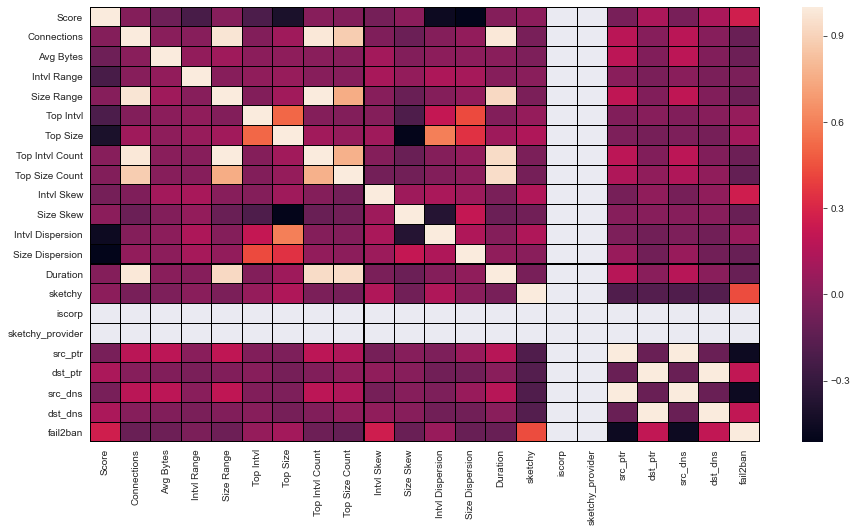

In [77]:
fig= plt.figure(figsize=(15,8))
sns.heatmap(df.corr(), linewidths=.1, linecolor='black')

### adding viz and stats

What are the most prevalent AS Numbers?

<AxesSubplot:>

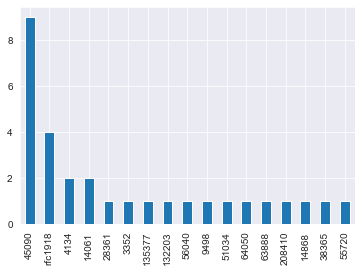

In [78]:
df['asn'][:30].value_counts().plot(kind='bar')

Where are they coming from?

<AxesSubplot:>

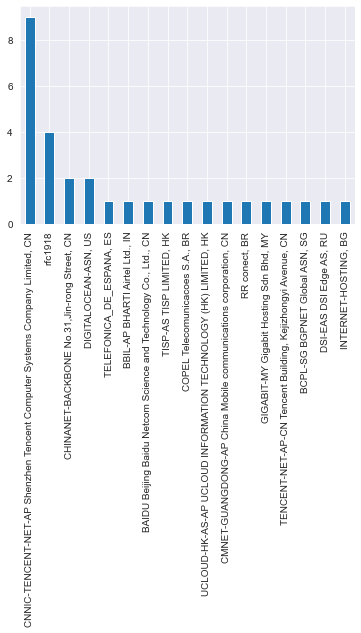

In [79]:
df['asn_desc'][:30].value_counts().plot(kind='bar')

What countries account for the most traffic?

<AxesSubplot:>

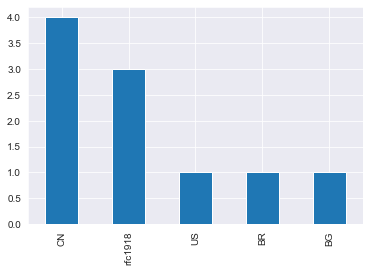

In [80]:
df['asn_country'][:10].value_counts().plot(kind='bar')

Is there a correlation between average bytes and number of connections?

<AxesSubplot:>

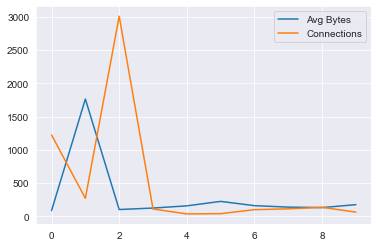

In [81]:
df[['Avg Bytes','Connections']][:10].plot()

**whats the relative occurrance of high beacon traffic?**

How about the occurrange of high beaconish traffic?

<AxesSubplot:>

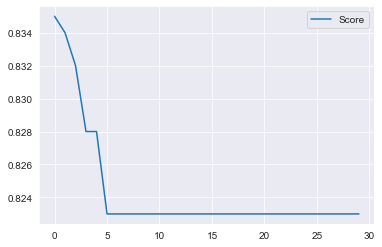

In [82]:
df[['Score']][:30].plot(y='Score')

<AxesSubplot:xlabel='Score'>

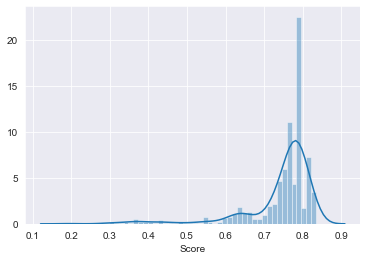

In [83]:
sns.distplot(df['Score'])

**how about long duration**

<AxesSubplot:xlabel='Duration'>

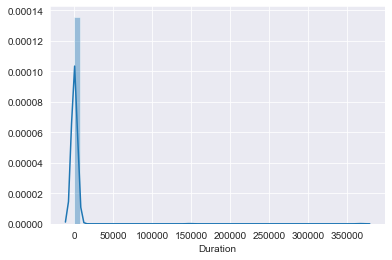

In [84]:
sns.distplot(df['Duration'])

#### how about services?


<AxesSubplot:>

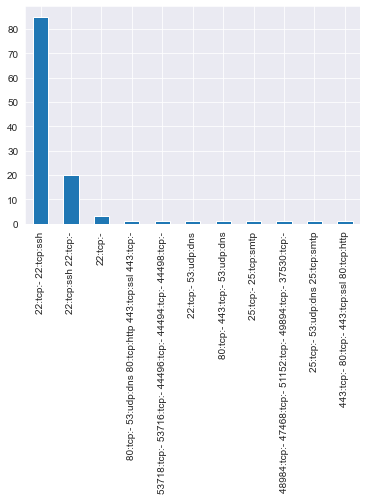

In [85]:
# The highest hits is fail2ban attempting to quash traffic, so we'll remove the ICMP entries
df[~df['Port:Protocol:Service'].str.contains('icmp')]['Port:Protocol:Service'].value_counts().plot(kind='bar')

### High Beaconish Originators

In [86]:
df[(df['Score'] >.80)][3:]['asn_desc']

3                                                rfc1918
4      TENCENT-NET-AP-CN Tencent Building, Kejizhongy...
5                                   DIGITALOCEAN-ASN, US
6      CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...
7            CHINANET-BACKBONE No.31,Jin-rong Street, CN
                             ...                        
110    CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...
111    TATACOMM-AS TATA Communications formerly VSNL ...
112    CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...
113    CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...
114                                                 None
Name: asn_desc, Length: 112, dtype: object

In [87]:
df['asn_country'].value_counts()

CN         293
US         118
rfc1918    115
FR          23
SG          16
HK          15
BR          15
IN          13
ID          11
RU          11
CA          11
KR          10
VN           9
IT           7
GB           6
MX           6
TH           5
JP           5
CO           4
IR           4
PH           4
SC           4
AR           3
PT           3
DE           3
ZA           2
PA           2
MY           2
AU           2
BG           2
CL           2
TW           2
MM           1
NG           1
PS           1
PL           1
VE           1
BO           1
SV           1
KE           1
TN           1
GR           1
LA           1
EG           1
BE           1
EC           1
PK           1
MN           1
TR           1
SE           1
IS           1
HR           1
GT           1
PE           1
ES           1
BY           1
CH           1
NL           1
Name: asn_country, dtype: int64

In [88]:
# highest traffic country entries
df[df['asn_country'] =='CN']

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,asn_desc,asn_country,sketchy,iscorp,sketchy_provider,src_ptr,dst_ptr,src_dns,dst_dns,fail2ban
4,0.828,192.168.23.89,119.28.83.164,38,159,241,2192,62,88,9,...,"TENCENT-NET-AP-CN Tencent Building, Kejizhongy...",CN,True,False,False,False,False,False,False,True
6,0.823,192.168.23.89,49.233.77.12,102,162,268,2564,85,88,15,...,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,CN,True,False,False,False,False,False,False,True
7,0.823,192.168.23.89,27.128.236.189,114,140,162,2036,80,88,19,...,"CHINANET-BACKBONE No.31,Jin-rong Street, CN",CN,True,False,False,False,False,False,False,True
9,0.823,192.168.23.89,118.24.134.15,65,177,153,2152,136,88,11,...,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,CN,True,False,False,False,False,False,False,True
10,0.823,192.168.23.89,106.54.72.65,38,238,458,1984,222,88,6,...,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,CN,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747,0.342,192.168.23.89,218.92.0.175,28,676,555991,1780,111,264,1,...,"CHINANET-BACKBONE No.31,Jin-rong Street, CN",CN,True,False,False,False,False,False,False,True
749,0.316,192.168.23.89,221.131.165.86,44,1558,125209,2108,1775,264,1,...,CMNET-JIANGSU-AP China Mobile communications c...,CN,True,False,False,False,False,False,False,True
750,0.310,192.168.23.89,221.181.185.29,70,1710,65032,2052,1750,2220,2,...,CMNET-JIANGSU-AP China Mobile communications c...,CN,True,False,False,False,False,False,False,True
751,0.301,192.168.23.89,182.61.52.98,41,521,1430,4728,176,88,4,...,BAIDU Beijing Baidu Netcom Science and Technol...,CN,True,False,False,False,False,False,False,True


### build a view of connections where duration value is short and beaconish is high

In [89]:
# What are the relative duration statistics?
df['Duration'].describe()

count       754.000000
mean        838.921720
std       14412.220971
min          99.789500
25%         116.089750
50%         129.967000
75%         162.906000
max      367302.000000
Name: Duration, dtype: float64

In [90]:
# What is the relative score distribution?
df['Score'].describe()

count    754.000000
mean       0.743745
std        0.093160
min        0.195000
25%        0.739000
50%        0.771000
75%        0.789000
max        0.835000
Name: Score, dtype: float64

In [91]:
# looking at raw duration length values
df['Duration'].sort_values()

706        99.7895
720        99.7956
455       100.1650
697       100.2780
714       100.6400
          ...     
751      1430.5600
404      2029.6400
2        7123.6100
646    148167.0000
529    367302.0000
Name: Duration, Length: 754, dtype: float64

**Start drilling down**

In [92]:
# 
df['Duration'].mean()

838.9217202917771

In [93]:
# Show only durations below the mean
df[df['Duration'] < df['Duration'].mean()]

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,asn_desc,asn_country,sketchy,iscorp,sketchy_provider,src_ptr,dst_ptr,src_dns,dst_dns,fail2ban
0,0.835,65.254.18.118,192.168.23.89,1224,88,101090,7306,600,60,1052,...,rfc1918,rfc1918,False,False,False,True,False,True,False,False
1,0.834,104.153.105.82,192.168.23.89,272,1762,356385,147842,1,0,81,...,rfc1918,rfc1918,False,False,False,True,False,True,False,False
3,0.828,49.235.37.144,192.168.23.89,112,126,179,1853,44,60,26,...,rfc1918,rfc1918,False,False,False,False,False,False,False,False
4,0.828,192.168.23.89,119.28.83.164,38,159,241,2192,62,88,9,...,"TENCENT-NET-AP-CN Tencent Building, Kejizhongy...",CN,True,False,False,False,False,False,False,True
5,0.823,192.168.23.89,157.230.210.84,42,226,220,1944,208,88,7,...,"DIGITALOCEAN-ASN, US",US,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,0.334,192.168.23.89,202.153.37.194,34,1452,801,4576,197,704,3,...,"EXCELL-AS Excellmedia, IN",IN,True,False,False,False,False,False,False,True
749,0.316,192.168.23.89,221.131.165.86,44,1558,125209,2108,1775,264,1,...,CMNET-JIANGSU-AP China Mobile communications c...,CN,True,False,False,False,False,False,False,True
750,0.310,192.168.23.89,221.181.185.29,70,1710,65032,2052,1750,2220,2,...,CMNET-JIANGSU-AP China Mobile communications c...,CN,True,False,False,False,False,False,False,True
752,0.287,192.168.23.89,221.181.185.135,33,1619,153173,1956,1748,2220,1,...,CMNET-JIANGSU-AP China Mobile communications c...,CN,True,False,False,False,False,False,False,True


**what are connections where duration is below a particular quantile?**

In [94]:
df[df['Duration'] < df['Duration'].quantile(.2)]

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,asn_desc,asn_country,sketchy,iscorp,sketchy_provider,src_ptr,dst_ptr,src_dns,dst_dns,fail2ban
3,0.828,49.235.37.144,192.168.23.89,112,126,179,1853,44,60,26,...,rfc1918,rfc1918,False,False,False,False,False,False,False,False
22,0.823,192.168.23.89,121.4.115.189,92,147,101,1792,91,88,16,...,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,CN,True,False,False,False,False,False,False,True
30,0.823,192.168.23.89,115.159.157.154,47,188,210,2072,96,88,7,...,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,CN,True,False,False,False,False,False,False,True
38,0.817,192.168.23.89,150.158.165.134,40,225,555819,1840,232,88,7,...,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,CN,True,False,False,False,False,False,False,True
47,0.817,45.119.126.59,192.168.23.89,62,268,261612,1801,163,60,8,...,rfc1918,rfc1918,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,0.380,195.54.160.250,192.168.23.89,68,998,91180,4020,4,40,12,...,rfc1918,rfc1918,False,False,False,False,False,False,False,False
740,0.369,45.93.201.193,192.168.23.89,82,768,99183,4020,3,40,11,...,rfc1918,rfc1918,False,False,False,False,False,False,False,False
743,0.368,120.92.79.133,192.168.23.89,102,246,705762,1801,7,60,45,...,rfc1918,rfc1918,False,False,False,False,False,False,False,False
745,0.354,118.70.233.206,192.168.23.89,103,235,714,1801,7,60,46,...,rfc1918,rfc1918,False,False,False,False,False,False,False,False


**connections where duration value is short and beaconish is high**

- only get low duration connections which exhibit above %75 beaconism 

In this case, there a bunch of ICMP messages originating from my host heading to (mostly) China. If fail2ban wasn't running this might be cause for further investigation, but fail2ban sends ICMP type 3 packets to an originator when it gets jailed. We're catching this upstream in the fail2ban column. 

In [95]:
print(len(df[(df['Duration'] < df['Duration'].quantile(.2)) & (df['Score'] > .75)]))
df[(df['Duration'] < df['Duration'].quantile(.2)) & (df['Score'] > .75)][:3]

82


,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,asn_desc,asn_country,sketchy,iscorp,sketchy_provider,src_ptr,dst_ptr,src_dns,dst_dns,fail2ban
3,0.828,49.235.37.144,192.168.23.89,112,126,179,1853,44,60,26,...,rfc1918,rfc1918,False,False,False,False,False,False,False,False
22,0.823,192.168.23.89,121.4.115.189,92,147,101,1792,91,88,16,...,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,CN,True,False,False,False,False,False,False,True
30,0.823,192.168.23.89,115.159.157.154,47,188,210,2072,96,88,7,...,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,CN,True,False,False,False,False,False,False,True


**if anything is left that's not fail2ban there is something to dig further into**

In [96]:
# if anything is left that's not fail2ban there is something to dig further into
df[(df['Duration'] < df['Duration'].quantile(.2)) & (df['Score'] > .75)&(~df['fail2ban'])]

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,asn_desc,asn_country,sketchy,iscorp,sketchy_provider,src_ptr,dst_ptr,src_dns,dst_dns,fail2ban
3,0.828,49.235.37.144,192.168.23.89,112,126,179,1853,44,60,26,...,rfc1918,rfc1918,False,False,False,False,False,False,False,False
47,0.817,45.119.126.59,192.168.23.89,62,268,261612,1801,163,60,8,...,rfc1918,rfc1918,False,False,False,False,False,False,False,False
56,0.817,120.70.98.132,192.168.23.89,58,277,672,1713,167,60,6,...,rfc1918,rfc1918,False,False,False,False,False,False,False,False
70,0.817,61.221.64.5,192.168.23.89,46,243,599,1801,150,60,6,...,rfc1918,rfc1918,False,False,False,True,False,True,False,False
74,0.812,202.95.14.159,192.168.23.89,50,323,1025,1941,213,60,5,...,rfc1918,rfc1918,False,False,False,False,False,False,False,False
75,0.812,190.210.182.179,192.168.23.89,51,186,1160,1841,167,60,5,...,rfc1918,rfc1918,False,False,False,True,False,True,False,False
124,0.793,106.124.131.214,192.168.23.89,156,139,200,1777,49,60,18,...,rfc1918,rfc1918,False,False,False,False,False,False,False,False
131,0.793,157.131.240.195,192.168.23.89,63,268,855,1969,161,60,9,...,rfc1918,rfc1918,False,False,False,True,False,True,False,False
149,0.793,49.232.39.21,192.168.23.89,119,154,287,1853,88,60,13,...,rfc1918,rfc1918,False,False,False,False,False,False,False,False
150,0.793,211.219.18.186,192.168.23.89,59,277,1517,1801,168,60,6,...,rfc1918,rfc1918,False,False,False,False,False,False,False,False


In [97]:
# is anything not originating from my ip?
df[(df['Duration'] < df['Duration'].quantile(.2)) & (df['Score'] > .75)]['Source IP'].unique()

array(['49.235.37.144', '192.168.23.89', '45.119.126.59', '120.70.98.132',
       '61.221.64.5', '202.95.14.159', '190.210.182.179',
       '106.124.131.214', '157.131.240.195', '49.232.39.21',
       '211.219.18.186', '123.206.90.149', '190.85.94.106',
       '49.233.77.12', '114.219.157.97', '210.178.94.227',
       '118.212.146.30', '106.75.61.147', '35.220.253.166',
       '119.45.177.219', '125.5.180.84', '134.175.111.215',
       '134.209.41.198', '189.110.163.26', '116.228.233.91',
       '190.171.133.10', '144.91.70.164', '101.89.213.84',
       '118.98.96.184', '64.64.227.224', '222.168.18.227', '103.10.87.54',
       '203.195.207.85', '101.36.127.150', '2.196.193.181',
       '123.127.244.100', '121.241.244.92', '182.254.149.130',
       '81.68.243.13', '106.124.142.64', '1.220.185.149', '123.30.149.34',
       '103.55.62.78', '118.24.121.227', '120.92.166.166',
       '121.4.138.185', '49.235.29.185', '140.249.222.242',
       '121.5.60.195', '96.69.13.140', '220.164.250.31'

In [98]:
# look at only non-fail2ban items where Duration is in the upper quantile, Score is greater than .75 and originates from my server
# nothing here - so it looks like beaconish activity here is fail2ban related (handled by )
df[(df['Duration'] < df['Duration'].quantile(.2)) & (df['Score'] > .75)& (~df['fail2ban']) &(df['Source IP'].str.contains('10.4.86.55'))]

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,asn_desc,asn_country,sketchy,iscorp,sketchy_provider,src_ptr,dst_ptr,src_dns,dst_dns,fail2ban


In [99]:
df[(df['Duration'] < df['Duration'].quantile(.2)) & (df['Score'] > .75)&(df['Source IP'] != '10.4.86.55')]

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,asn_desc,asn_country,sketchy,iscorp,sketchy_provider,src_ptr,dst_ptr,src_dns,dst_dns,fail2ban
3,0.828,49.235.37.144,192.168.23.89,112,126,179,1853,44,60,26,...,rfc1918,rfc1918,False,False,False,False,False,False,False,False
22,0.823,192.168.23.89,121.4.115.189,92,147,101,1792,91,88,16,...,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,CN,True,False,False,False,False,False,False,True
30,0.823,192.168.23.89,115.159.157.154,47,188,210,2072,96,88,7,...,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,CN,True,False,False,False,False,False,False,True
38,0.817,192.168.23.89,150.158.165.134,40,225,555819,1840,232,88,7,...,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,CN,True,False,False,False,False,False,False,True
47,0.817,45.119.126.59,192.168.23.89,62,268,261612,1801,163,60,8,...,rfc1918,rfc1918,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.756,192.168.23.89,174.138.6.46,32,265,292,1896,281,88,4,...,"DIGITALOCEAN-ASN, US",US,False,False,False,False,False,False,False,True
497,0.756,192.168.23.89,42.194.198.187,74,149,122,1716,108,88,7,...,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,CN,True,False,False,False,False,False,False,True
505,0.755,96.69.13.140,192.168.23.89,73,238,715,1969,143,60,6,...,rfc1918,rfc1918,False,False,False,True,False,True,False,False
510,0.753,192.168.23.89,125.60.148.184,40,189,506,1568,217,72,3,...,"SMARTBRO-PH-AP Smart Broadband, Inc., PH",PH,False,False,False,False,False,False,False,True


In [100]:
def showline(ipaddress):
    return df[df['Source IP'] == ipaddress]

In [101]:
showline('223.247.137.208')

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,asn_desc,asn_country,sketchy,iscorp,sketchy_provider,src_ptr,dst_ptr,src_dns,dst_dns,fail2ban


In [102]:
# where are ssh connections coming/going?
# everything appears to be incoming, so we aren't launching any attacks
df[(df['Port:Protocol:Service'].str.contains('ssh')) & (df['Source IP'] != "10.4.86.55")]['ConnString'].unique()

array(['49.235.37.144->192.168.23.89', '42.192.234.75->192.168.23.89',
       '45.119.126.59->192.168.23.89', '120.70.98.132->192.168.23.89',
       '61.221.64.5->192.168.23.89', '202.95.14.159->192.168.23.89',
       '190.210.182.179->192.168.23.89', '106.124.131.214->192.168.23.89',
       '157.131.240.195->192.168.23.89', '49.232.39.21->192.168.23.89',
       '211.219.18.186->192.168.23.89', '123.206.90.149->192.168.23.89',
       '190.85.94.106->192.168.23.89', '49.233.77.12->192.168.23.89',
       '114.219.157.97->192.168.23.89', '210.178.94.227->192.168.23.89',
       '118.212.146.30->192.168.23.89', '106.75.61.147->192.168.23.89',
       '129.211.119.202->192.168.23.89', '35.220.253.166->192.168.23.89',
       '119.45.177.219->192.168.23.89', '125.5.180.84->192.168.23.89',
       '134.175.111.215->192.168.23.89', '134.209.41.198->192.168.23.89',
       '189.110.163.26->192.168.23.89', '116.228.233.91->192.168.23.89',
       '190.171.133.10->192.168.23.89', '144.91.70.164->192.16

## add total score 

In [103]:
# def tally_total(item):
#     badclasses = ['sketchy','has_ptr','src_ptr','dst_ptr','iscorp','sketchy_provider','src_dns','dst_dns','fail2ban']
#     total=0
#     if item['fail2ban'] or item['sketchy'] or item['sketchy_provider']:
#         total +=1
#     if 
        
        